## IDS576 - Team 3
#### Training CIFAR with Basic CNN and Random Feature Nullification

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time

In [8]:
%config IPCompleter.greedy = True
random_seed = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
import numpy as np
def get_train_data_stats(train_data):
    # use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array\
    x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
    print(x.shape)
    # calculate the mean and std along the (0, 1) axes
    train_mean = np.mean(x, axis=(0, 1))
    train_std = np.std(x, axis=(0, 1))
    print(train_mean, train_std)
    return train_mean, train_std

In [10]:
# load the training data for determination of mean and std
data_path = '~/IDS576/data'
train_data = datasets.CIFAR10(root=data_path, train=True, download=True)
train_mean, train_std = get_train_data_stats(train_data)
print(train_mean/255, train_std/255)

Files already downloaded and verified
(1600000, 32, 3)
[125.30691805 122.95039414 113.86538318] [62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [11]:
normalize = transforms.Normalize(
    mean=train_mean/255,
    std=train_std/255)

train_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize])
    
val_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize])

In [12]:
# Download train and test data
data_path = '~/IDS576/data'
trainset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=train_transform)
valset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=val_transform)
testset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Split train data in to train and validation data using torch dataset and utils.data modules

val_size = .2
n_train = len(trainset)

# get train set indices and split point based on val size
indices = list(range(n_train))
split = int(np.floor(val_size * n_train))

# shuffle trainset indices
np.random.seed(random_seed)
np.random.shuffle(indices)

# split train into train and val with shuffled indices at split point. 
train_idx, val_idx = indices[split:], indices[:split]

# Create train and val samplers based in split indices for use with DataLoader batch sampling
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

batch_size = 20
n_trn = n_train*(1-val_size)
batches = n_trn/batch_size

# CUDA settings
num_workers = 0 # allows preload of next batch, but greater than zero isn't recommended for cuda ops
pin_memory = True

train_dl = DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

val_dl = DataLoader(
    valset, batch_size=batch_size, sampler=val_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

def single_dl(xy, batch_size=1):
    return DataLoader(xy, batch_size=batch_size, num_workers=1, pin_memory=pin_memory)

In [14]:
classes = trainset.classes
classdict = {label: name for label, name in enumerate(classes)}
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [15]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    xb = xb.to(device)
    yb = yb.to(device)
    correct = 0
    output = model(xb)
    _, preds = torch.max(output, 1)
    correct = torch.sum(preds == yb)
    acc = correct.double()/len(yb)
    loss = loss_func(output, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb), acc   

def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    mod = n_trn/(batch_size*20)
    running_corrects = 0
    val_accs = []
    val_losses = []
    for epoch in range(epochs):
        since = time.time()
        model.train()
        #i=0
        print(f'Epoch {epoch+1}/{epochs}: [', end='')
        for i, (xb, yb) in enumerate(train_dl):
            if not i % mod:
                print('*', end='')
            loss_batch(model, loss_func, xb, yb, opt)
            #i+=1
        print(']', end='')
        model.eval()
        print(' Val Loss: ', end='')
        with torch.no_grad():
            losses, nums, acc = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in val_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(acc, nums)) / np.sum(nums)
        
        # Save history
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'{val_loss:6.4f}, Val Acc: {val_acc:6.4f} ', end='')
        until = time.time()
        print(f'Elapsed (sec): {until-since:<5.1f}')
    return val_accs, val_losses

In [68]:
class CIFAR(nn.Module):
    
    def __init__(self):
        super(CIFAR, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.batchnorm1 = nn.BatchNorm2d(32, affine=False)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64, affine=False)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128, affine=False)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout = nn.Dropout(p=.2)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.pool = nn.MaxPool2d(2, 2)
                             
    def forward(self, x):
        x = self.batchnorm1(self.conv1(x))
        x = self.pool(F.relu(x))
        x = self.batchnorm2(self.conv2(x))
        x = self.pool(F.relu(x))
        x = self.batchnorm3(self.conv3(x))
        x = self.pool(F.relu(x))
        x = x.view(-1, 128 * 4 * 4) 
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x


In [65]:
import torch.nn as nn
import torch
import numpy as np

class RFN(nn.Module):
    '''Wrapper class that takes any nn.Module based model and adds an RFN layer prior to all other layers.'''
    
    
    def __init__(self, model, mu=.1, sigma=.05, rfn_flag=True):
        super(RFN, self).__init__()
        self.model = model
        self.mu = mu
        self.sigma = sigma
        self.rfn_flag = rfn_flag
        self.shape_vals = None

    def forward(self, x):
        if self.rfn_flag:
            x = self.random_masks(x) * x
            x = self.model(x)
        else:
            x = self.model(x)
        return x
    
    
    def random_masks(self, x):
        # Set various shape values once to speed processing
        if self.shape_vals is None:
            self.shape_vals = x.size(), x[0].size(), x[0].nelement()
            #print(self.shape_vals)

        # Create ones array of size (batch,channel,horiz,vert)
        masks = np.ones(self.shape_vals[0])

        # Create random masks for each sample in the batch
        for mask in masks:
            zero_cnt = np.absolute(int(np.ceil((self.sigma * np.random.randn() + self.mu) * self.shape_vals[2])))
            zero_idx = np.random.choice(self.shape_vals[2], zero_cnt, replace=False)
            mask.reshape(self.shape_vals[2])[zero_idx] = 0
            mask.reshape(self.shape_vals[1])
        return torch.tensor(masks, dtype=torch.float, device=device)

In [66]:
from collections import defaultdict
# Create history dict for all models with validation accuracy and loss per epoch
history = defaultdict(list)

In [74]:
# Train CIFAR without RFN as reference
epochs = 5
mnist_ref = CIFAR()
mnist_ref.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(mnist_ref.parameters(), lr=0.001, momentum=0.9)
history[0] = fit(epochs, mnist_ref, loss_func, opt, train_dl, val_dl)

Epoch 1/5: [********************] Val Loss: 1.5766, Val Acc: 0.4800 Elapsed (sec): 24.3 
Epoch 2/5: [********************] Val Loss: 1.0576, Val Acc: 0.6263 Elapsed (sec): 23.3 
Epoch 3/5: [********************] Val Loss: 0.9663, Val Acc: 0.6576 Elapsed (sec): 22.7 
Epoch 4/5: [********************] Val Loss: 0.8586, Val Acc: 0.6939 Elapsed (sec): 22.9 
Epoch 5/5: [********************] Val Loss: 0.8168, Val Acc: 0.7130 Elapsed (sec): 23.0 


In [75]:
# Train CIFAR without RFN as reference
epochs = 5
mnist_ref = CIFAR()
mnist_ref.to(device)
rfn_wrapper = RFN(mnist_ref, mu=.1, sigma=.05, rfn_flag=True)
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(mnist_ref.parameters(), lr=0.001, momentum=0.9)
history[0] = fit(epochs, rfn_wrapper, loss_func, opt, train_dl, val_dl)

Epoch 1/5: [********************] Val Loss: 1.2870, Val Acc: 0.5254 Elapsed (sec): 36.1 
Epoch 2/5: [********************] Val Loss: 1.0752, Val Acc: 0.6165 Elapsed (sec): 34.7 
Epoch 3/5: [********************] Val Loss: 0.9893, Val Acc: 0.6452 Elapsed (sec): 34.4 
Epoch 4/5: [********************] Val Loss: 0.9430, Val Acc: 0.6598 Elapsed (sec): 35.3 
Epoch 5/5: [********************] Val Loss: 0.8745, Val Acc: 0.6917 Elapsed (sec): 35.0 


In [70]:
# Bulk Train CIFAR models: reference and several RFN mu values

rfn_mu_vals = [0, .1, .2, .3, .4, .5]
epochs = 10

for mu in rfn_mu_vals:
    print(f'Training RFN, mu={mu}:')
    
    # Set whether RFN will be used in training
    if mu == 0:
        rfn_flag = False
    else:
        rfn_flag = True
             
    cifar_rfn = CIFAR()
    cifar_rfn.to(device)
    rfn_wrapper = RFN(cifar_rfn, mu=.1, sigma=.05, rfn_flag=rfn_flag)
    rfn_wrapper.to(device)
    
    loss_func = nn.CrossEntropyLoss()
    opt = optim.SGD(cifar_rfn.parameters(), lr=0.001, momentum=0.9)
    
    history[mu] = fit(epochs, rfn_wrapper, loss_func, opt, train_dl, val_dl)
    
    # Save model
    PATH = f'./models/CIFAR_rfn_{mu}.pth'
    torch.save(mnist_ref.state_dict(), PATH)

Training RFN, mu=0:
Epoch 1/10: [********************] Val Loss: 1.3365, Val Acc: 0.5138 Elapsed (sec): 22.9 
Epoch 2/10: [********************] Val Loss: 1.0245, Val Acc: 0.6290 Elapsed (sec): 23.0 
Epoch 3/10: [********************] Val Loss: 0.9395, Val Acc: 0.6663 Elapsed (sec): 23.2 
Epoch 4/10: [********************] Val Loss: 0.8430, Val Acc: 0.7022 Elapsed (sec): 23.3 
Epoch 5/10: [********************] Val Loss: 0.8264, Val Acc: 0.7063 Elapsed (sec): 23.0 
Epoch 6/10: [********************] Val Loss: 0.8001, Val Acc: 0.7201 Elapsed (sec): 23.3 
Epoch 7/10: [********************] Val Loss: 0.7289, Val Acc: 0.7437 Elapsed (sec): 22.9 
Epoch 8/10: [********************] Val Loss: 0.6973, Val Acc: 0.7618 Elapsed (sec): 23.3 
Epoch 9/10: [********************] Val Loss: 0.7215, Val Acc: 0.7527 Elapsed (sec): 23.1 
Epoch 10/10: [********************] Val Loss: 0.6790, Val Acc: 0.7689 Elapsed (sec): 23.5 
Training RFN, mu=0.1:
Epoch 1/10: [********************] Val Loss: 1.2508, Val 

In [71]:
import pickle
with open('./models/cifar_history.pkl', 'wb') as f:
    pickle.dump(history, f)

In [72]:
with open('./models/cifar_history.pkl', 'rb') as f:
    history = pickle.load(f)

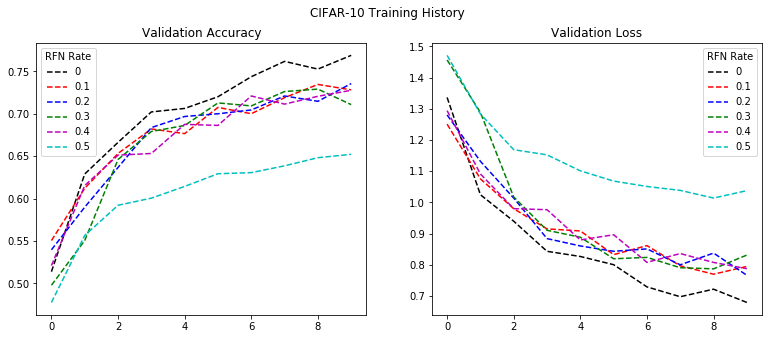

In [73]:
import matplotlib.pyplot as plt

colors = ['k', 'r', 'b', 'g', 'm', 'c']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
fig.suptitle('CIFAR-10 Training History')
ax[0].set_title('Validation Accuracy')
ax[1].set_title('Validation Loss')
for c, (k, v) in zip(colors, history.items()):
    ax[0].plot(range(10), v[0], c+'--', label=str(k))
    ax[1].plot(range(10), v[1], c+'--', label=str(k))
ax[0].legend(title='RFN Rate')
ax[1].legend(title='RFN Rate')